# Dota Science

### - A tutorial in using the OpenDota API and analyzing, wrangling, and interpreting data

Dota2 is an online multiplayer game categorized as a MOBA. The complexities run deep in this 8 year old game and with constant updates and changes, there is no definite "best" way to play. Playstyle is determined by many factors such as desire to win, current meta, and even personality. While some play for fun, most play to win. With a healthy competetive scene, some players struggle to improve their rank and often lay the blame on their team members.

In this guide we will learn how to use the OpenDota API to gather statistics about matches and players. Furthermore, we will also perform lots of data wrangling to take a somewhat cluttered API return into clean and useful data. 

What actually matters in Dota? Are you focusing on the wrong things? Rather than compare yourself to others, this guide focuses on finding which stats actually have an effect on your wins and losses.

A big thank you to our volunteer who allowed me to analyze their recent matches and use their account as a demo.

## Using the OpenDota API

https://docs.opendota.com/#tag/matches%2Fpaths%2F~1matches~1%7Bmatch_id%7D%2Fget

OpenDota is a website that provides its very own Dota API. While valve has one as well, we will be focusing on OpenDota for this guide.

Lets begin by installing and importing the necessary packages.

In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests


Here we make our first request to ensure the API is working.

In [159]:
re = requests.get("https://api.opendota.com/api/players/107567514/matches?api_key=e134eec0-7025-4c2a-9e4b-502796efc9ec")

Then we proceed to save the data and import it into a Pandas Dataframe

In [4]:
import json
with open('data.txt', 'w') as outfile:
    json.dump(re.json(), outfile)

In [5]:
import pandas as pd

In [6]:
allmatchdf = pd.read_json(json.dumps(re.json()))

In [7]:
allmatchdf

,match_id,player_slot,radiant_win,duration,game_mode,lobby_type,hero_id,start_time,version,kills,deaths,assists,skill,leaver_status,party_size
0,6326439621,0,False,1974,22,0,71,2021-12-17 21:59:15,21.0,3,7,8,3.0,0,2.0
1,6326376051,3,True,2258,22,0,90,2021-12-17 21:10:21,21.0,3,7,12,3.0,0,2.0
2,6326209566,131,True,1420,22,0,50,2021-12-17 19:22:37,21.0,0,7,4,3.0,0,2.0
3,6326109870,128,False,1532,22,0,135,2021-12-17 18:24:42,21.0,2,2,9,3.0,0,2.0
4,6326026400,0,True,1735,22,0,5,2021-12-17 17:38:16,21.0,3,3,24,3.0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,429956825,1,True,2473,1,0,42,2013-12-18 22:11:46,NaN,3,5,8,NaN,0,NaN
5653,429917919,1,False,2616,1,0,6,2013-12-18 21:21:37,NaN,4,16,11,NaN,0,NaN
5654,423710538,131,True,1731,1,0,16,2013-12-15 02:32:59,NaN,0,12,3,NaN,0,NaN
5655,423672586,3,False,1973,1,0,19,2013-12-15 01:53:31,NaN,0,15,0,NaN,0,NaN


Immediately we see some issues with our Dataset. Lots of the older matches have FAR less data and honestly won't provide much insight anyway as it was 8 years ago as well. We will begin by simply performing a dropna to remove all NaN points.

In [8]:
allmatchdf = allmatchdf.dropna()

For some reason, there is no team indication other than an 8 bit number. This will be annoying to constantly convert so lets make it easier for ourselves.

In [9]:
for index, row in allmatchdf.iterrows():
    if row['player_slot'] >= 128:
        allmatchdf.loc[index,'team'] = "dire"
    else:
        allmatchdf.loc[index,'team'] = "radiant"

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Additionally, lets bring in a win/loss value

In [10]:
for index, row in allmatchdf.iterrows():
    if row.loc['radiant_win'] == True and row.loc['team'] == "radiant":
        allmatchdf.at[index,'result'] = "win"
    elif row.loc['radiant_win'] == False and row.loc['team'] == "dire":
        allmatchdf.at[index,'result'] = "win"
    else:
        allmatchdf.at[index,'result'] = "loss"

In [11]:
winsdf = allmatchdf.loc[(allmatchdf['result'] == "win")]
lossdf = allmatchdf.loc[(allmatchdf['result'] == "loss")]
totalmatches = allmatchdf.count()[0]
allmatchdf

,match_id,player_slot,radiant_win,duration,game_mode,lobby_type,hero_id,start_time,version,kills,deaths,assists,skill,leaver_status,party_size,team,result
0,6326439621,0,False,1974,22,0,71,2021-12-17 21:59:15,21.0,3,7,8,3.0,0,2.0,radiant,loss
1,6326376051,3,True,2258,22,0,90,2021-12-17 21:10:21,21.0,3,7,12,3.0,0,2.0,radiant,win
2,6326209566,131,True,1420,22,0,50,2021-12-17 19:22:37,21.0,0,7,4,3.0,0,2.0,dire,loss
3,6326109870,128,False,1532,22,0,135,2021-12-17 18:24:42,21.0,2,2,9,3.0,0,2.0,dire,win
4,6326026400,0,True,1735,22,0,5,2021-12-17 17:38:16,21.0,3,3,24,3.0,0,2.0,radiant,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3487,3350509542,1,False,2517,4,0,103,2017-08-01 21:35:24,20.0,3,11,7,1.0,0,3.0,radiant,loss
3488,3350469605,2,True,1834,4,0,71,2017-08-01 20:54:30,20.0,8,4,29,1.0,0,4.0,radiant,win
3489,3350237823,129,False,1929,4,0,28,2017-08-01 17:41:07,20.0,13,5,23,1.0,0,5.0,dire,win
3490,3346568101,0,False,1238,4,0,60,2017-07-30 20:03:21,20.0,2,2,0,1.0,0,1.0,radiant,loss


## Party Size

Lets start off with something super simple just to get a feel for how our data works/looks. It would not be fun if we setup a complex model only to realize something is wrong.

Lets purely analyze winrate based off of your party size.

In [12]:
#Solo winrate
solowr = winsdf.loc[(winsdf['party_size'] == 1.0)].count()[0] / allmatchdf.loc[(allmatchdf['party_size'] == 1.0)].count()[0]
#Duo winrate
duowr = winsdf.loc[(winsdf['party_size'] == 2.0)].count()[0] / allmatchdf.loc[(allmatchdf['party_size'] == 2.0)].count()[0]
#Trio winrate
triowr = winsdf.loc[(winsdf['party_size'] == 3.0)].count()[0] / allmatchdf.loc[(allmatchdf['party_size'] == 3.0)].count()[0]
#Quad winrate
quadwr = winsdf.loc[(winsdf['party_size'] == 4.0)].count()[0] / allmatchdf.loc[(allmatchdf['party_size'] == 4.0)].count()[0]
#5stack winrate
fivewr = winsdf.loc[(winsdf['party_size'] == 5.0)].count()[0] / allmatchdf.loc[(allmatchdf['party_size'] == 5.0)].count()[0]


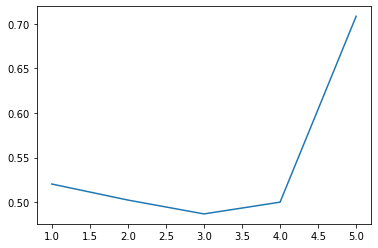

In [13]:
from matplotlib import pyplot as plt
size = [1,2,3,4,5]
wr = [solowr,duowr,triowr,quadwr,fivewr]
plt.plot(size,wr)
plt.show()

5 Stacks are clearly an outlier, but apparently a high outlier. Lets remove 4 and 5 and take a look at more normal matches.

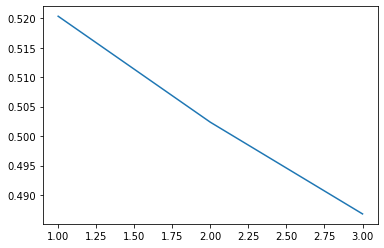

In [14]:
size = [1,2,3]
wr = [solowr,duowr,triowr]
plt.plot(size,wr)
plt.show()

While the difference is small, is is noticeabe, solo queuing has almost a 3% advantage over trio queuing.

# Better Data

We're really only given so much data from this request. Fortunately, we have another api call that requests a Match ID, and returns large amounts of data and an entire array of all players in the game. The work we've done so far is still helpful because the new json returns in the form of sub array of player positions which we now already have.

Unfortunately, the API has been giving me lots of issues lately with being abnormally slow and returning quite a few errors. For this reason we only take a random sample of 100 matches. Feel free in your project to use as many data points as you want, the more the merrier. 

Also the free version of the API only allows 60 calls a minute, so I went ahead and purchased an API key allowing 1500 calls a minute for easier testing/debugging of this tutorial. The key you see will no longer work as I have reset mine after posting this tutorial.

In [15]:
responses = []
for index, row in allmatchdf.sample(n=100).iterrows():
    url = "https://api.opendota.com/api/matches/" + str(row['match_id'])+"?api_key=e134eec0-7025-4c2a-9e4b-502796efc9ec"
    re = requests.get(url)
    if re.status_code == 200:
        responses.append(re.json())

In [16]:
from io import StringIO
temp = json.dumps(responses)
newdf = pd.read_json(StringIO(temp))

In [17]:
newdf

,match_id,barracks_status_dire,barracks_status_radiant,chat,cluster,cosmetics,dire_score,dire_team_id,draft_timings,duration,...,players,patch,region,all_word_counts,my_word_counts,comeback,stomp,replay_url,throw,loss
0,6263730714,63,0,"[{'time': -41, 'type': 'chat', 'key': 'grandma...",123,"{'647': 129, '4794': 3, '5531': 130, '7396': 4...",31,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",2395,...,"[{'match_id': 6263730714, 'player_slot': 0, 'a...",49,2,"{'grandmaster': 1, 'spirit': 2, 'breaker': 2, ...",{},1143.0,23555.0,http://replay123.valve.net/570/6263730714_1218...,NaN,NaN
1,3832919429,0,51,"[{'time': -71, 'type': 'chat', 'unit': 'frick'...",122,"{'647': 1, '4999': 131, '5000': 131, '5001': 1...",55,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",3987,...,"[{'match_id': 3832919429, 'player_slot': 0, 'a...",32,2,"{'sorry': 3, 'im': 4, 'esperne': 1, 'lag': 3, ...",{},NaN,NaN,NaN,30573.0,11028.0
2,5959711691,48,63,"[{'time': 140, 'type': 'chatwheel', 'key': '71...",123,"{'647': 132, '4442': 4, '4484': 0, '4911': 128...",18,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",2148,...,"[{'match_id': 5959711691, 'player_slot': 0, 'a...",48,2,"{'good': 1, 'job': 1, 'mid': 1, 'you': 1, 'got...",{},NaN,NaN,http://replay123.valve.net/570/5959711691_1778...,6316.0,9234.0
3,3389020979,0,63,"[{'time': 1128, 'type': 'chat', 'unit': '5580I...",122,"{'4041': 2, '5354': 1, '5617': 131, '5618': 13...",25,NaN,None,2004,...,"[{'match_id': 3389020979, 'player_slot': 0, 'a...",25,2,"{'ayuda': 1, 'gg': 3, 'gwp': 1}",{},NaN,NaN,NaN,33.0,20033.0
4,5640143957,63,3,"[{'time': -62, 'type': 'chatwheel', 'key': '7'...",111,"{'630': 128, '4637': 0, '4686': 2, '4687': 2, ...",37,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",2357,...,"[{'match_id': 5640143957, 'player_slot': 0, 'a...",46,1,"{'haha': 2, 'just': 3, 'coime': 1, 'iwthus': 1...",{},7488.0,15705.0,http://replay111.valve.net/570/5640143957_1278...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,4997413159,51,0,"[{'time': -225, 'type': 'chat', 'unit': 'Sorno...",122,"{'647': 129, '4644': 0, '4647': 0, '5915': 130...",41,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",3462,...,"[{'match_id': 4997413159, 'player_slot': 0, 'a...",41,2,"{'you': 33, 'fucking': 9, 'faggot': 3, 'ni': 4...",{},763.0,28393.0,NaN,NaN,NaN
88,5816989560,0,63,"[{'time': -74, 'type': 'chat', 'unit': 'Dota-D...",122,"{'602': 131, '4683': 128, '4684': 128, '4812':...",24,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",3025,...,"[{'match_id': 5816989560, 'player_slot': 0, 'a...",47,2,"{'nice': 1, 'boosting': 1, 'services': 1, 'lol...",{},NaN,NaN,http://replay122.valve.net/570/5816989560_4136...,3971.0,14257.0
89,5347573529,51,63,"[{'time': -84, 'type': 'chatwheel', 'key': '7'...",111,"{'602': 129, '647': 132, '4412': 0, '4416': 0,...",43,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",3278,...,"[{'match_id': 5347573529, 'player_slot': 0, 'a...",44,1,"{'c': 1, 'patience': 1, 'misclick': 1, 'lol': ...",{},NaN,NaN,http://replay111.valve.net/570/5347573529_1022...,13202.0,273.0
90,5849386592,3,63,"[{'time': -64, 'type': 'chatwheel', 'key': '11...",122,"{'647': 131, '4961': 131, '7103': 128, '7104':...",11,NaN,"[{'order': 1, 'pick': False, 'active_team': 2,...",1601,...,"[{'match_id': 5849386592, 'player_slot': 0, 'a...",47,2,"{'gg': 3, 'wp': 1, 'ggpw': 1, 'ggwp': 1, 'so':...",{},NaN,NaN,http://replay122.valve.net/570/5849386592_2384...,0.0,26849.0


We are now almost where we were previously. Lets extract the data for our player in question.

Since we're just looking at our one player we need to extract all the information from his respective player position/category

In [26]:
savedplayer = []
for index, row in newdf.iterrows():
    for player in row['players']:
        if player['account_id'] == 107567514:
            savedplayer.append(player)

In [47]:
finaldataframe = pd.DataFrame(savedplayer)
finaldataframe

,match_id,player_slot,ability_targets,ability_upgrades_arr,ability_uses,account_id,actions,additional_units,assists,backpack_0,...,item_win,item_usage,purchase_ward_observer,purchase_ward_sentry,purchase_tpscroll,actions_per_min,life_state_dead,rank_tier,cosmetics,benchmarks
0,6263730714,2,{},"[5237, 5238, 5237, 5239, 5237, 5240, 5237, 523...","{'rattletrap_battery_assault': 25, 'rattletrap...",107567514,"{'1': 3506, '2': 128, '3': 20, '4': 491, '5': ...",None,13,216,...,"{'tango': 0, 'flask': 0, 'enchanted_mango': 0,...","{'tango': 1, 'flask': 1, 'enchanted_mango': 1,...",6.0,11.0,4.0,123,173,55,"[{'item_id': 7466, 'name': 'Paraflare Cannon',...","{'gold_per_min': {'raw': 246, 'pct': 0.0728155..."
1,3832919429,1,{'shadow_shaman_ether_shock': {'npc_dota_hero_...,"[5080, 5078, 5078, 5080, 5078, 5081, 5078, 507...","{'shadow_shaman_ether_shock': 32, 'shadow_sham...",107567514,"{'1': 6622, '2': 242, '3': 20, '4': 420, '5': ...",None,19,0,...,"{'branches': 1, 'clarity': 1, 'tango': 1, 'enc...","{'branches': 1, 'clarity': 1, 'tango': 1, 'enc...",19.0,21.0,10.0,123,766,55,"[{'item_id': 8341, 'name': 'Shade of the Spite...","{'gold_per_min': {'raw': 263, 'pct': 0.2100628..."
2,5959711691,131,{'dark_willow_cursed_crown': {'npc_dota_hero_c...,"[6339, 6341, 6341, 6342, 6341, 8340, 6341, 633...","{'dark_willow_bramble_maze': 29, 'dark_willow_...",107567514,"{'1': 3994, '2': 99, '3': 1, '4': 295, '5': 58...",None,5,0,...,"{'flask': 0, 'faerie_fire': 0, 'enchanted_mang...","{'flask': 1, 'faerie_fire': 1, 'enchanted_mang...",3.0,6.0,3.0,137,281,55,"[{'item_id': 11266, 'name': 'The Watcher Below...","{'gold_per_min': {'raw': 239, 'pct': 0.1249107..."
3,3389020979,129,None,"[5448, 5450, 5450, 5448, 5450, 5452, 5450, 544...","{'rubick_telekinesis': 9, 'rubick_telekinesis_...",107567514,"{'1': 3095, '2': 78, '3': 1, '4': 222, '5': 36...",None,6,0,...,"{'ward_observer': 0, 'wind_lace': 0, 'tango': ...","{'ward_observer': 1, 'wind_lace': 1, 'tango': ...",9.0,3.0,8.0,115,345,55,"[{'item_id': 8061, 'name': 'Taunt: Giddy Up!',...","{'gold_per_min': {'raw': 265, 'pct': 0.1520390..."
4,5640143957,1,{'crystal_maiden_frostbite': {'npc_dota_hero_m...,"[5126, 5128, 5127, 5128, 5126, 5129, 5126, 512...","{'crystal_maiden_crystal_nova': 58, 'crystal_m...",107567514,"{'1': 2825, '2': 91, '3': 12, '4': 434, '5': 1...",None,13,8,...,"{'flask': 0, 'clarity': 0, 'enchanted_mango': ...","{'flask': 1, 'clarity': 1, 'enchanted_mango': ...",12.0,19.0,NaN,101,329,55,"[{'item_id': 9041, 'name': 'Taunt: Making Frie...","{'gold_per_min': {'raw': 293, 'pct': 0.3967696..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,4997413159,1,{'undying_soul_rip': {'npc_dota_hero_skeleton_...,"[5442, 5443, 5444, 5444, 5444, 5447, 5444, 544...","{'undying_decay': 81, 'undying_soul_rip': 49, ...",107567514,"{'1': 5177, '2': 332, '3': 31, '4': 885, '5': ...",None,22,0,...,"{'stout_shield': 0, 'enchanted_mango': 0, 'fla...","{'stout_shield': 1, 'enchanted_mango': 1, 'fla...",NaN,NaN,8.0,136,391,55,"[{'item_id': 7938, 'name': 'Pale Augur', 'pref...","{'gold_per_min': {'raw': 350, 'pct': 0.5009861..."
88,5816989560,4,{'grimstroke_spirit_walk': {'npc_dota_hero_gri...,"[8000, 8007, 8007, 8006, 8000, 6491, 8007, 800...","{'grimstroke_dark_artistry': 67, 'grimstroke_s...",107567514,"{'1': 5121, '2': 190, '3': 27, '4': 526, '5': ...",None,22,0,...,"{'flask': 1, 'faerie_fire': 1, 'enchanted_mang...","{'flask': 1, 'faerie_fire': 1, 'enchanted_mang...",6.0,15.0,3.0,138,229,55,"[{'item_id': 10132, 'name': 'Na'Vi's Weaselcro...","{'gold_per_min': {'raw': 330, 'pct': 0.5488902..."
89,5347573529,128,{},"[6344, 7307, 6344, 7307, 6344, 6343, 6344, 730...","{'pangolier_swashbuckle': 120, 'pangolier_gyro...",107567514,"{'1': 6064, '2': 241, '3': 124, '4': 976, '5':...",None,19,21,...,"{'quelling_blade': 0, 'tango': 0, 'enchanted_m...","{'quelling_blade': 1, 'tango': 1, 'enchanted_m...",NaN,NaN,12.0,155,502,55,"[{'item_id': 9208, 'name': 'Etienne's Revenge'...","

Good Work! We are now almost done with some of the biggest data wrangling portion. Lets replace some NaN values with 0s along with bringing our previously computed win/loss back in.

In [126]:
finaldataframe['purchase_ward_sentry'] = finaldataframe['purchase_ward_sentry'].fillna(0)
finaldataframe['purchase_ward_observer'] = finaldataframe['purchase_ward_observer'].fillna(0)
finaldataframe['result'] = "loss"
for index, row in finaldataframe.iterrows():
    if allmatchdf.loc[allmatchdf['match_id'] == row['match_id']].iloc[0]['result'] == "win":
        finaldataframe.at[index,'result'] = "win"

# Vision

Lets graph some more complex data with our newly wrangled Data.

Vision is a crucial part to any Dota match. Playing in the dark can be painful, but do the numbers tell the same story?

In [127]:
#cases = ["winsent","winobs","losssent","lossobs"]
cases = [0,1,2,3]
visionperwins = [finaldataframe[finaldataframe.result == "win"]["purchase_ward_sentry"].values,
                              finaldataframe[finaldataframe.result == "win"]["purchase_ward_observer"].values,
                              finaldataframe[finaldataframe.result == "loss"]["purchase_ward_sentry"].values,
                              finaldataframe[finaldataframe.result == "loss"]["purchase_ward_observer"].values]
import math

clean = []
for row in visionperwins:
    clean.append([x for x in row if math.isnan(x) == False])

Text(0.5, 1.0, 'Vision purchase affecting Win/Loss')

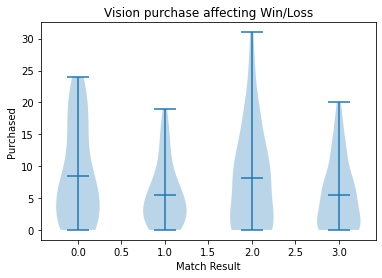

In [128]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()


axes.violinplot(clean,cases,widths=.5,showmeans=True)
axes.set_xlabel("Match Result")
axes.set_ylabel("Purchased")
axes.set_title("Vision purchase affecting Win/Loss")

From this violin plot alone, we can hardly say vision matters. An interesting observation. Lets try to back it up.

# Building Models

Much like Valve's already implemented dota plus win predictor, we can create our own ML model using different parameters to determine an outcome.

## Linear Regression

Lets start by predicting win/loss based off of vision like we previously did. We will need a dummy variable for winloss.

In [133]:
finaldataframe['dummywin'] = 0
for index, row in finaldataframe.iterrows():
    if row['result'] == "win":
        finaldataframe.at[index,'dummywin'] = 1

For the following Linear Regression Models we will be using stasmodel ols. Lets see if a linear model confirms out hypothesis. https://www.statsmodels.org/stable/index.html

In [143]:
from statsmodels.formula.api import ols

mod = ols("dummywin ~ purchase_ward_sentry + purchase_ward_observer", data=finaldataframe)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               dummywin   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                   0.04750
Date:                Sun, 19 Dec 2021   Prob (F-statistic):              0.954
Time:                        18:53:41   Log-Likelihood:                -65.934
No. Observations:                  92   AIC:                             137.9
Df Residuals:                      89   BIC:                             145.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

Much like our previous graph we can see that surprisingly enough ward purchases don't have a massive impact on the result of the game. So much so that neither of the variables, nor the interaction is statistically significant.

In [135]:
for col in finaldataframe.columns:
    print(col)

match_id
player_slot
ability_targets
ability_upgrades_arr
ability_uses
account_id
actions
additional_units
assists
backpack_0
backpack_1
backpack_2
backpack_3
buyback_log
camps_stacked
connection_log
creeps_stacked
damage
damage_inflictor
damage_inflictor_received
damage_taken
damage_targets
deaths
denies
dn_t
firstblood_claimed
gold
gold_per_min
gold_reasons
gold_spent
gold_t
hero_damage
hero_healing
hero_hits
hero_id
item_0
item_1
item_2
item_3
item_4
item_5
item_neutral
item_uses
kill_streaks
killed
killed_by
kills
kills_log
lane_pos
last_hits
leaver_status
level
lh_t
life_state
max_hero_hit
multi_kills
net_worth
obs
obs_left_log
obs_log
obs_placed
party_id
party_size
performance_others
permanent_buffs
pings
pred_vict
purchase
purchase_log
randomed
repicked
roshans_killed
rune_pickups
runes
runes_log
sen
sen_left_log
sen_log
sen_placed
stuns
teamfight_participation
times
tower_damage
towers_killed
xp_per_min
xp_reasons
xp_t
personaname
name
last_login
radiant_win
start_time
duration

Lets explore some more variables. Feel free to try out other ones too that you are curious about.

In [142]:
mod = ols("dummywin ~ kills + assists + deaths", data=finaldataframe)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               dummywin   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     16.68
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           1.16e-08
Time:                        18:53:26   Log-Likelihood:                -45.276
No. Observations:                  92   AIC:                             98.55
Df Residuals:                      88   BIC:                             108.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3048      0.118      2.585      0.0

This is very intuitive as well. We see assists and deaths mattering a lot. But kills not as much which makes sense for our support player.

In a game like dota, arguably one of the most important factors is the hero you play. While we could just look at hero winrate, that is boring, so lets make a model based off of hero-id

In [138]:
mod = ols("dummywin ~ C(hero_id)", data=finaldataframe)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               dummywin   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                 -0.105
Method:                 Least Squares   F-statistic:                    0.7775
Date:                Sun, 19 Dec 2021   Prob (F-statistic):              0.792
Time:                        18:29:37   Log-Likelihood:                -44.851
No. Observations:                  92   AIC:                             169.7
Df Residuals:                      52   BIC:                             270.6
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5000      0.37

Without a staggering winrate on any hero, a linear regression model will never show that one hero is more significant than the other. Since most hero winrates average around 50% on this account, the linear regression model sees them as very insignificant.

Lets try a super broad attack to see if we can discover any unexpected information.

In [144]:
for col in finaldataframe.columns:
    print(col)

match_id
player_slot
ability_targets
ability_upgrades_arr
ability_uses
account_id
actions
additional_units
assists
backpack_0
backpack_1
backpack_2
backpack_3
buyback_log
camps_stacked
connection_log
creeps_stacked
damage
damage_inflictor
damage_inflictor_received
damage_taken
damage_targets
deaths
denies
dn_t
firstblood_claimed
gold
gold_per_min
gold_reasons
gold_spent
gold_t
hero_damage
hero_healing
hero_hits
hero_id
item_0
item_1
item_2
item_3
item_4
item_5
item_neutral
item_uses
kill_streaks
killed
killed_by
kills
kills_log
lane_pos
last_hits
leaver_status
level
lh_t
life_state
max_hero_hit
multi_kills
net_worth
obs
obs_left_log
obs_log
obs_placed
party_id
party_size
performance_others
permanent_buffs
pings
pred_vict
purchase
purchase_log
randomed
repicked
roshans_killed
rune_pickups
runes
runes_log
sen
sen_left_log
sen_log
sen_placed
stuns
teamfight_participation
times
tower_damage
towers_killed
xp_per_min
xp_reasons
xp_t
personaname
name
last_login
radiant_win
start_time
duration

Additionally, note that descriptions for these tags can be found here http://sharonkuo.me/dota2/matchdetails.html

In [158]:
mod = ols("dummywin ~ camps_stacked + gold_per_min + hero_damage + hero_healing + pings + actions_per_min", data=finaldataframe)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               dummywin   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     4.626
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           0.000446
Time:                        20:03:53   Log-Likelihood:                -48.884
No. Observations:                  86   AIC:                             111.8
Df Residuals:                      79   BIC:                             128.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1843      0.341     

GPM, hero dmg, healing, all make sense. They're important and you're doing them more if you're winning. Something to possibly note is the significance of stacking camps. It is significant HOWEVER, it has a negative weight, implying it is actually worse.

Another thing which is interesting is the amount of pinging is not relevant. Some may be surprised by this and some may not.

## Decision Trees

A more intuitive way to create a predictive model would be with a decision tree and random forest. Since we had to use a dummy var for win/loss is may be slightly skewing all of our results.

Lets grab some features that we believe are good indicators. We will be using SKLearn to build these models. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [148]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

feature_cols = ['camps_stacked', 'gold_per_min', 'hero_damage', 'hero_healing','deaths','assists']
X = finaldataframe[feature_cols] # Features
y = finaldataframe.result # Target variable

Method is based off guide here(https://www.datacamp.com/community/tutorials/decision-tree-classification-python)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

We will be using a 70/30 holdout validation to assess accuracy

In [151]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [152]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.75


In [153]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

The decision tree has given us a medium accuracy when holdout validation is used. Next lets compare to a random forest. Additionally, we used all default params/hyperparams.

75% accuracy is decent considering how much variation there is between these values between games

## Random Forests

Next up we will try a random forrest. Hypothetically, this should become more accurate. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Create Decision Tree classifer object
rclf = RandomForestClassifier()

# Train Decision Tree Classifer
rclf = rclf.fit(X_train,y_train)

#Predict the response for test dataset
ry_pred = rclf.predict(X_test)

In [156]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, ry_pred))

Accuracy: 0.8571428571428571


We will use the same 70-30 holdout validation here again to get an even higher accuracy.

In [157]:
rclf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

As expected the random forest is better, but a 10% increase is very significant and makes sense considering what we mentioned earlier. Each dota game is very different and hard to classify purely off of 6-7 stats

## Analyzing and Drawing Conclusions from our Data

Now that we've covered how to collect, wrangle, and analyze data, we need to draw some conclusions about what we've seen. In the case of this tutorial, we covered a wide variety of stats and either confirmed or rejected if they were relevant on the outcome of the game. In your case, you may be curious about other factors and interpret the results differently.

For example, stacking_camps ended up being relevant by our linear model. This isn't too unexpected, but the fact that it had a negative weight is. This implies that for some reason, the player in question is hurting themself by stacking camps. Why is that? Could it be because the enemy team is able to take the stacks before you are? Are your stacks getting stolen? Is it because you're leaving to stack at the wrong time and its hurting your team more than helping?

All these questions are productive and will help make you a better player. They will allow you to discover and improve on traits you may not have even questioned.

Looking forward, there are endless possibilities on how to use the DotaAPI to collect and analyze data. Another interesting factor might be chatlogs. I avoided them in this tutorial as they can be pretty toxic but how does chatting affect your gameplay? Are you losing more when you chat more? Are there certain words you say when you're losing?

Overall, the possibilities are endless and its up to you how you want to use this information. Remember, its important to follow a semi-rigid process of collect, wrangle, analyze, reflect.

Thank you for reading my tutorial. I hope you found it interesting and informative. If you have any questions or would simply like to learn more, feel free to contact me at jack.maiorino@gmail.com